# Processing

## Imports

In [1]:
import os
import re
import json
from datetime import datetime, timezone
from telethon.sync import TelegramClient
from deep_translator import GoogleTranslator
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Scraping Telegram channels

The code below can be used to scrape the content of Telegram channels via Telethon. One post on a channel can consist of more than one message. Each message contains text and/or media and is saved in a separate directory. To work with Telegram API you need your own API ID and hash (see [Telethon documentation](https://docs.telethon.dev/en/stable/basic/signing-in.html)).

In [2]:
# API_ID = 'YOUR_API_ID'
# API_HASH = 'YOUR_API_HASH'

# channels = ['emmanuelmacron']

# DATETIME_LIMIT = datetime(2021, 12, 1, 0, tzinfo=timezone.utc)
# AFTER_LIMIT = True
# MESSAGE_LIMIT = None
# FILESIZE_LIMIT = 0

# with TelegramClient('anon', API_ID, API_HASH) as client:
#     for channel in channels:
#         for message in client.iter_messages(channel, 
#                                             limit=MESSAGE_LIMIT,
#                                             offset_date=DATETIME_LIMIT, 
#                                             reverse=AFTER_LIMIT):
#             if message.file:
#                 file_size = message.file.size
#             else:
#                 file_size = 0
#             message_path = f"telegram_channels/{channel}/{message.id}_{message.date.strftime('%Y-%m-%d_%H-%M-%S')}_{file_size}"
#             os.makedirs(message_path, exist_ok=True)
#             if message.text:
#                 with open(f'{message_path}/text.txt', 'w') as f:
#                     f.write(message.text)
#             if message.media and (file_size <= FILESIZE_LIMIT):
#                 message.download_media(message_path)

## Loading the model

We are going to use [cardiffnlp/twitter-roberta-base-sentiment-latest](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) model which was trained on tweets and finetuned for sentiment analysis.

In [3]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Functions for sentiment analysis

In [4]:
link_re = re.compile("https?:\/\/[^\s\)\*]+") # could be improved


def compute_sentiment(text):
    """
    Compute the sentiment of a line of text (i.e., text without newlines).
    """
    num_chars = len(text)
    num_words = len(text.split(' '))
    # links are replaced with just "http" for this model
    new_text = link_re.sub('http', text)
    # we can use truncation=True and max_length=512 to avoid an error
    # but we also want to encode all the text
    encoded_text = tokenizer(new_text, return_tensors="pt")
    num_tokens = len(encoded_text['input_ids'][0])
    output = model(**encoded_text)
    scores = softmax(output[0][0].detach().numpy())
    neg, neu, pos = scores
    return {'stats': {'num_chars': num_chars,
                      'num_words': num_words,
                      'num_tokens': num_tokens
                    },
            'scores': {'negative': float(neg), 
                       'neutral': float(neu),
                       'positive': float(pos)
                      }
           }


def overall_sentiment(sentiment, weight_by='num_words'):
    """
    Compute the sentiment of a message using the weighted sentiment of each line.
    Also return "total" score as a number between -1 (negative) and +1 (positive).
    """
    if not sentiment:
        return {'scores': {'negative': 0.0,
                           'neutral': 0.0,
                           'positive': 0.0,
                           'total': 0.0},
                'weights': 0}
    neg = neu = pos = 0.0
    weights = 0
    for s in sentiment:
        weight = s['stats'][weight_by]
        neg += s['scores']['negative'] * weight
        neu += s['scores']['neutral'] * weight
        pos += s['scores']['positive'] * weight
        weights += weight
    neg /= weights
    neu /= weights
    pos /= weights
    neg_side = neg + neu/2
    total = 1.0 - 2.0 * neg_side 
    return {'scores': {'negative': neg,
                       'neutral': neu,
                       'positive': pos,
                       'total': total},
            'weights': weights}

## Loading data

In [5]:
# these IDs were renamed to correspond to the initials of people running their Telegram channels
channels = ['DM', 'DR', 'OA', 'RK', 'VK', 'VZ']
dfs = {}
for channel in channels:
    messages = {'id': [], 'datetime': [], 'words': [], 'media': [], 'sentiment': []}
    for msg in sorted(os.listdir(f'./telegram_channels/{channel}')):
        id_, date, time, media_size = msg.split('_')
        year, month, day = [int(i) for i in date.split('-')]
        hour, minute, second = [int(i) for i in time.split('-')]
        datetime_obj = datetime(year, month, day, hour=hour, minute=minute, second=second)
        media_size = int(media_size)
        msg_dir = f'./telegram_channels/{channel}/{msg}'
        msg_content = os.listdir(msg_dir)
       
        if 'sentiment.json' in msg_content:
            with open(f'{msg_dir}/sentiment.json', 'r') as f:
                sentiment = json.load(f)             
        elif 'en_text.txt' in msg_content:
            # en_text.txt > sentiment.json
            with open(f'{msg_dir}/en_text.txt', 'r') as f:
                en_lines = [en_line.strip() for en_line in f.readlines()]
            try:
                sentiment = [compute_sentiment(en_line) for en_line in en_lines]
            except RuntimeError:
                print(id_)
                continue
            with open(f'{msg_dir}/sentiment.json', 'w') as f:
                f.write(json.dumps(sentiment, indent=2))
        elif 'text.txt' in msg_content:
            # text.txt > en_text.txt > sentiment.json
            with open(f'{msg_dir}/text.txt', 'r') as f:
                lines = [line.strip() for line in f.readlines()]
            en_lines = []
            sentiment = []
            for line in lines:
                # NotValidPayload is raised by GoogleTranslator when line.isdigit() == True
                if line.isdigit():
                    en_line = line
                else:
                    en_line = GoogleTranslator(source='auto', target='en').translate(line)
                if en_line:
                    en_lines.append(en_line)
                    sentiment.append(compute_sentiment(en_line))
            with open(f'{msg_dir}/en_text.txt', 'w') as f:
                f.write('\n'.join(en_lines))
            with open(f'{msg_dir}/sentiment.json', 'w') as f:
                f.write(json.dumps(sentiment, indent=2))
        else:
            sentiment = None
        
        sentiment = overall_sentiment(sentiment, weight_by='num_words')
        messages['id'].append(int(id_))
        messages['datetime'].append(datetime_obj)
        messages['words'].append(sentiment['weights'])
        messages['media'].append(media_size)
        messages['sentiment'].append(sentiment['scores']['total'])
        
    dfs[channel] = pd.DataFrame(messages).sort_values(by='id').set_index('id')

In [6]:
# data of the last four posts taken from a well-known Telegram channel 
dfs['DM'].tail(4)

,datetime,words,media,sentiment
id,,,,
341,2023-06-17 16:04:23,80,736296,-0.757770
342,2023-06-23 13:09:08,61,0,-0.925779
343,2023-06-24 09:19:08,63,0,-0.379798
344,2023-06-30 14:44:06,250,0,-0.548164


# Results

In [7]:
figsize = (20, 10)
narrow_window = 14
wide_window = 30

## Plotting function

In [8]:
plt.rc('font', size=16) 

def plot_value(dfs, value='words', window_days=30, figsize=(20,8)):
    """
    Plot "words", "media", "posts", or "sentiment" using the center of a window.
    
    """
    
    legend_labels = sorted(dfs.keys())
    title_prefixes = {"words": "Words per day",
                      "media": "Media (MB) per day",
                      "posts": "Posts per day",
                      "sentiment": "Sentiment"}
    title = f"{title_prefixes[value]} ({window_days}-day window, center)"
    x_ticks = pd.date_range(start="2022-01-01", end="2023-06-15", freq="MS")
    fig, ax = plt.subplots(figsize=figsize)
    for channel in legend_labels:
        if value == "posts":
            df = dfs[channel][['datetime']].groupby('datetime').count()
            df['ones'] = 1
            df_window = df.rolling(f'{window_days}d', center=True).count() / window_days
        elif value == "sentiment":
            df_window = dfs[channel][dfs[channel]['words'] > 0.0].copy()
            df_window['sentiment'] *= df_window['words']
            df_window = df_window.set_index('datetime').rolling(f'{window_days}d', center=True).sum()
            df_window['sentiment'] /= df_window['words']
            df_window = df_window['sentiment']
        else:
            df = dfs[channel][['datetime', value]].set_index('datetime')
            df_window = df.rolling(f'{window_days}d', center=True).sum() / window_days
            df_window /= 1e6 if value == "media" else 1
        df_window.plot(ax=ax, xlabel='', legend=channel)
    ax.legend(legend_labels)
    _ = ax.set_title(title, fontsize=20)
    _ = ax.set_xticks(x_ticks)
    _ = ax.set_xticklabels(x_ticks, rotation=90, ha="center")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if value == 'sentiment':
        ax.set_ylim(bottom=-1, top=1)
    else:
        ax.set_ylim(bottom=0)
    ax.set_xlim(left=x_ticks[0], right=x_ticks[-1])
    ax.grid(which='major', axis='both')

## Posts per day

The number of posts is calculated as the number of unique timestamps (`.date` attributes of messages returned by  `TelegramClient.iter_messages()` of [Telethon API](https://docs.telethon.dev/en/stable/modules/client.html)).

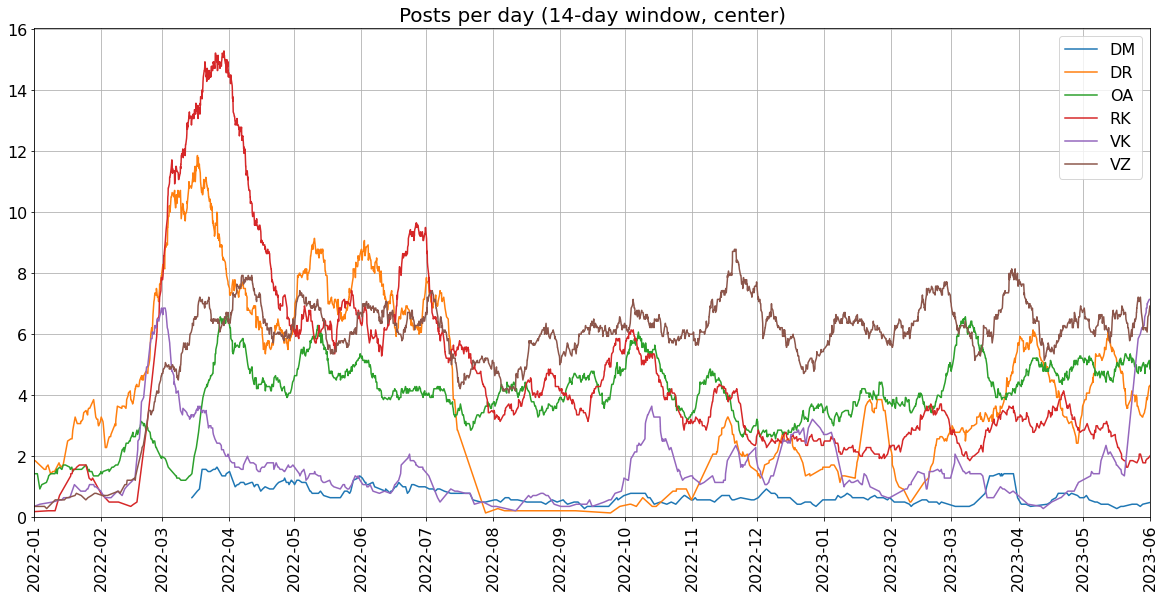

In [9]:
plot_value(dfs, value='posts', window_days=narrow_window, figsize=figsize)

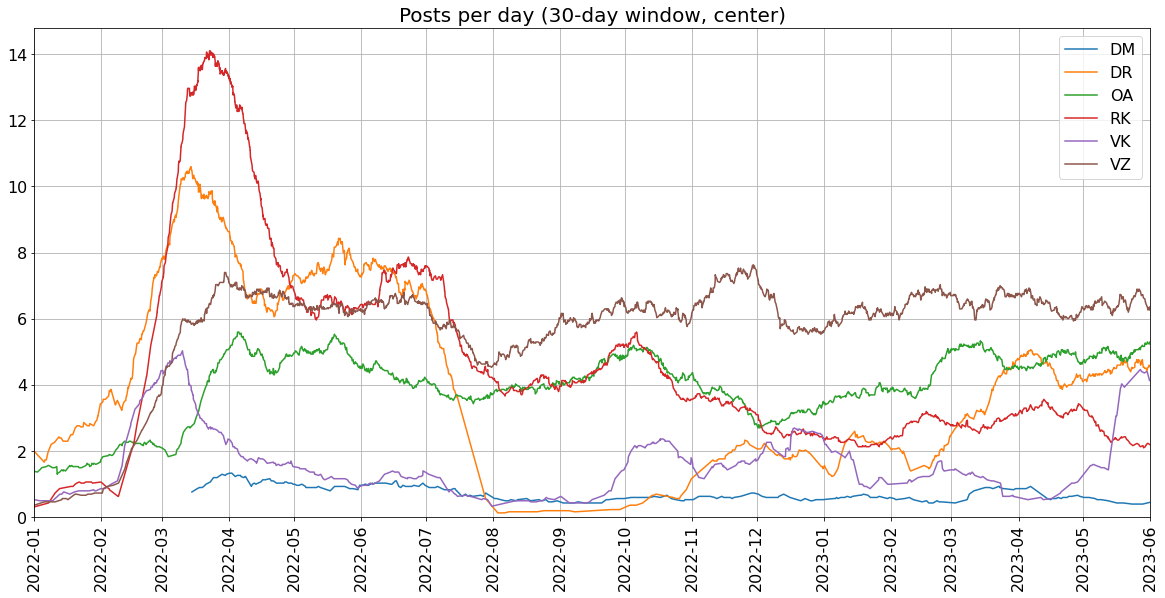

In [10]:
plot_value(dfs, value='posts', window_days=wide_window, figsize=figsize)

## Words per day

The number of words is defined as `len(translated_text.split(' '))`.

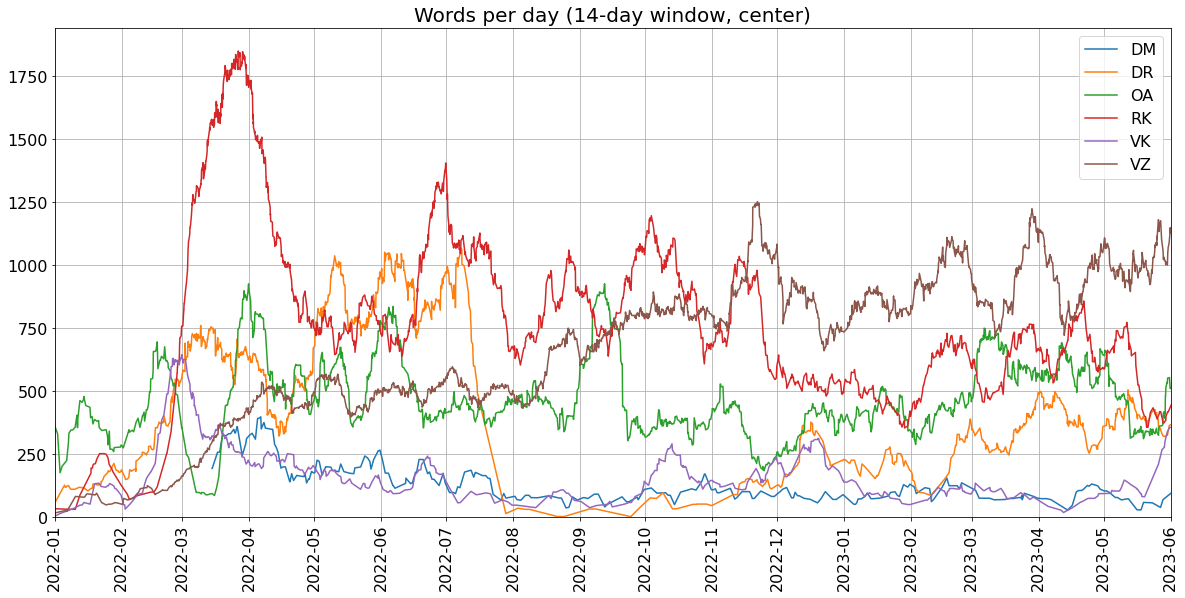

In [11]:
plot_value(dfs, value='words', window_days=narrow_window, figsize=figsize)

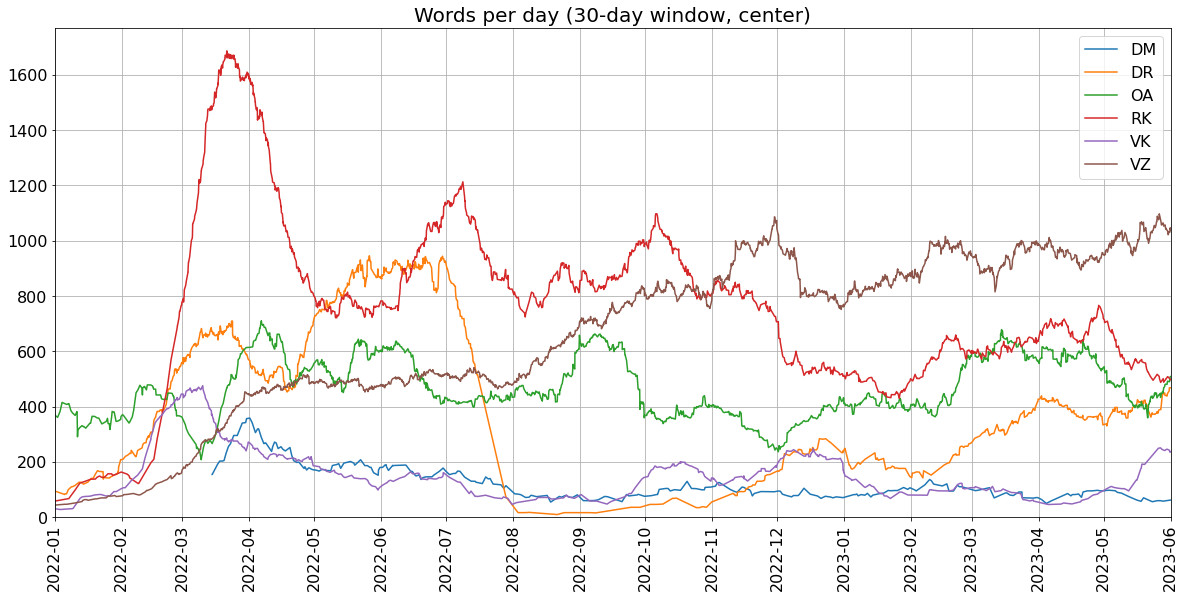

In [12]:
plot_value(dfs, value='words', window_days=wide_window, figsize=figsize)

## Media (MB) per day

File size is returned by `message.file.size` of [Telethon API](https://docs.telethon.dev/en/stable/modules/client.html).

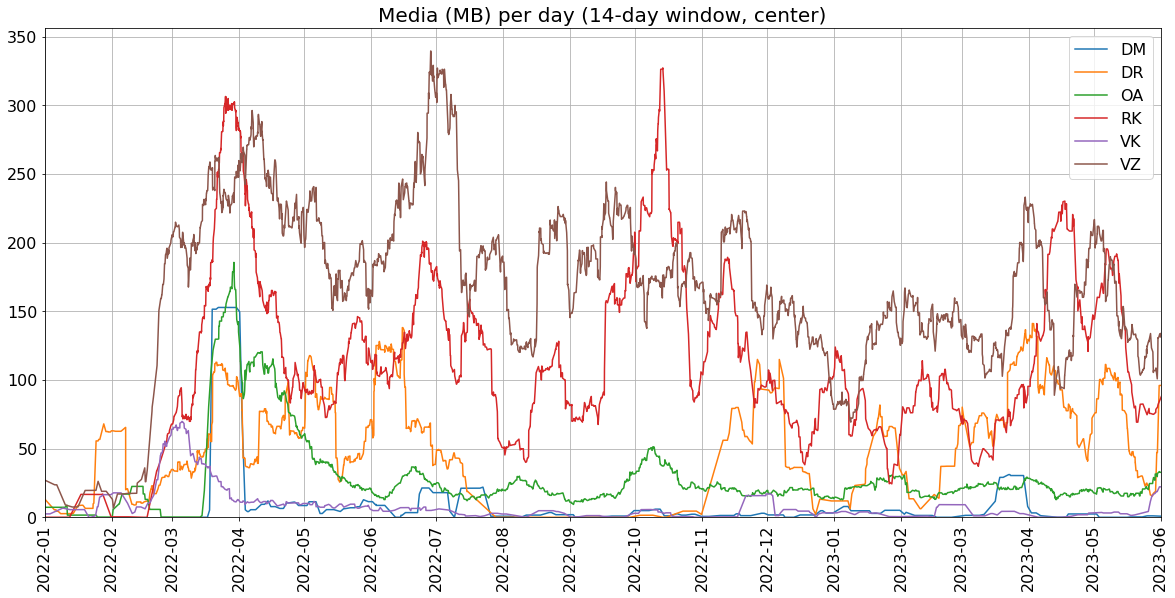

In [13]:
plot_value(dfs, value='media', window_days=narrow_window, figsize=figsize)

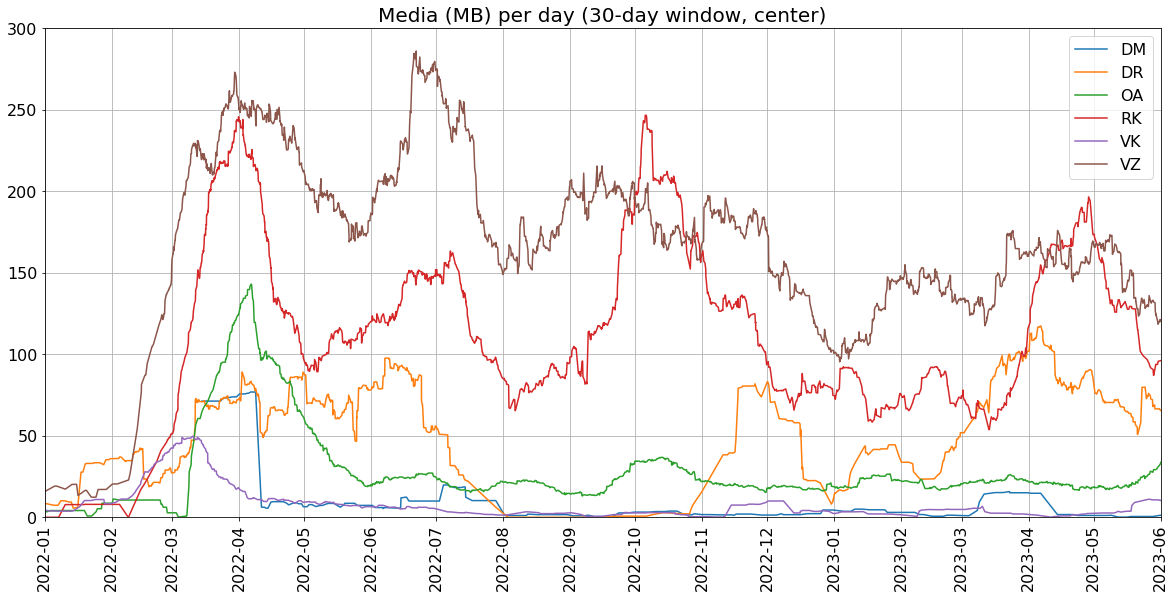

In [14]:
plot_value(dfs, value='media', window_days=wide_window, figsize=figsize)

## Sentiment weighted by the number of words

The sentiment plotted below is calculated as $\operatorname{Sentiment} = 1.0 - 2.0 \times (\operatorname{Negative} + \operatorname{Neutral} / 2)$, where $\operatorname{Negative} + \operatorname{Neutral} + \operatorname{Positive} = 1$. This gives a value for $\operatorname{Sentiment}$ between $-1$ and $1$.

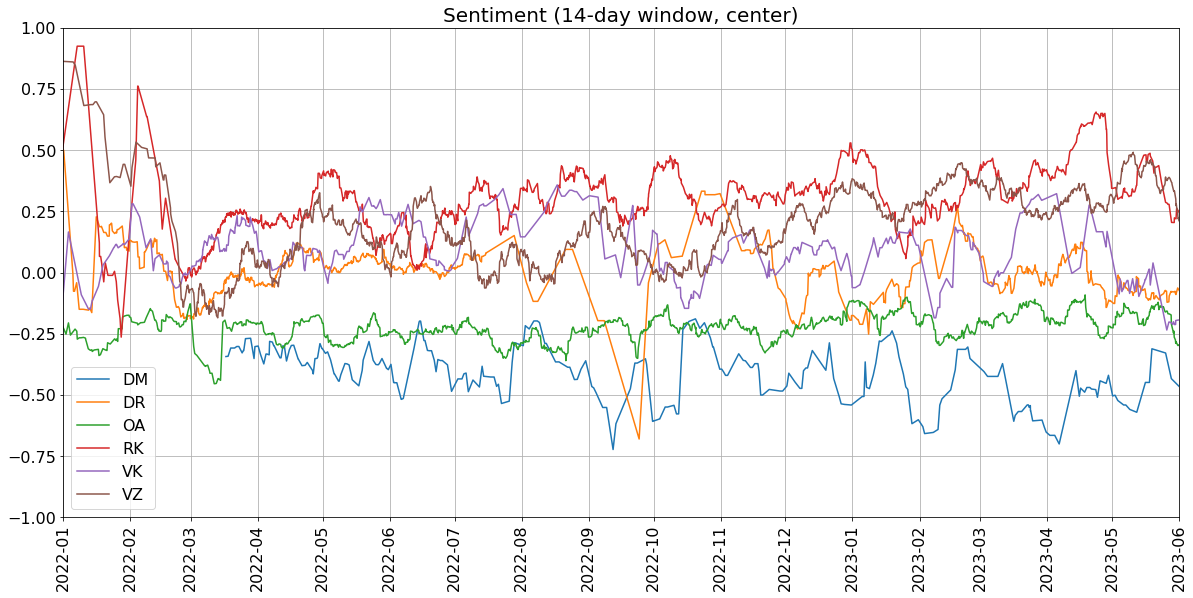

In [15]:
plot_value(dfs, value='sentiment', window_days=narrow_window, figsize=figsize)

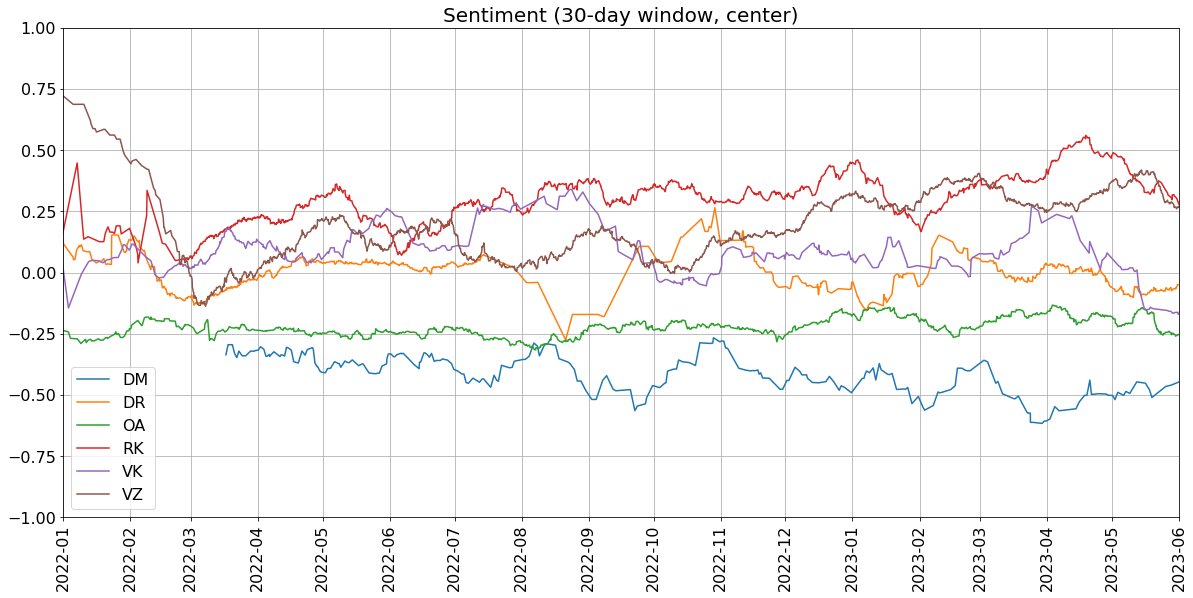

In [16]:
plot_value(dfs, value='sentiment', window_days=wide_window, figsize=figsize)